In [1]:
#importing dependencies

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

from GCNConv import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from graph import *

# Loading Data

In [2]:
g = np.load('facebook.npz')

In [3]:
g.files

['edges', 'features', 'target']

In [4]:
# Get the edges, features and target(label) of the graph
edges = g['edges']
X = g['features']
target = g['target']

In [5]:
# Get adjacency matrix
A = get_adj_mat(edges)

In [6]:
X.shape

(22470, 128)

In [7]:
# Number of nodes
N = X.shape[0]

In [8]:
# Number of features
F = X.shape[1]

In [9]:
# Number of Classes
num_classes = len(np.unique(target))

In [10]:
print("Number of nodes: {}\nNumber of features: {}\nNumber of classes: {}".format(N,F,num_classes))

Number of nodes: 22470
Number of features: 128
Number of classes: 4


# Select examples for training, validation, and test then set the mask

In [11]:
def split_data(target, N, limit=400,val_num=5000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in target)
    train_idx = []
    test_num = N - limit*len(np.unique(target)) - val_num
    for i in range(len(target)):
        label = target[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 400 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(target)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

# Numbers of samples: Training: 1600, Validation: 4000, Test: 15870
train_idx,val_idx,test_idx = split_data(target,N)

In [12]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [13]:
# Convert the target with one-hot
target = to_categorical(target)

# Building and training a multi-layer GCN model

In [14]:
# Parameters
channels_1 = 32          # Number of channels in the first GCN layer
channels_2 = 8           # Number of channels in the second GCN layer
dropout = 0.5           # Dropout rate for the features
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping


# Model definition
X_in = Input(shape=(F, ))
node_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
GCNconv_1 = GCNConv(channels_1, activation='relu')([dropout_1, node_in])

dropout_2 = Dropout(dropout)(GCNconv_1)
GCNconv_2 = GCNConv(channels_2, activation='relu')([dropout_2, node_in])

dropout_3 = Dropout(dropout)(GCNconv_2)
GCNconv_2 = GCNConv(num_classes, activation='softmax')([dropout_3, node_in])

# Build model
model = Model(inputs=[X_in, node_in], outputs=GCNconv_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', weighted_metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22470)]      0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, 32)           4096        dropout[0][0]                    
                                                                 input_2[0][0]                

In [15]:
# Normalised the adjacency matrix
A = get_adj_mat_hat(A)

Instructions for updating:
Use `tf.linalg.matmul` instead


In [16]:
# Train model
validation_data = ([X, A], target, val_mask)
model.fit([X, A],
          target,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False
 )

Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 0.0997 - acc: 0.3281 - val_loss: 0.2837 - val_acc: 0.4980
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.0922 - acc: 0.3994 - val_loss: 0.2649 - val_acc: 0.5278
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.0876 - acc: 0.4381 - val_loss: 0.2491 - val_acc: 0.5450
Epoch 4/200
1/1 [==============================] - 1s 982ms/step - loss: 0.0833 - acc: 0.4575 - val_loss: 0.2358 - val_acc: 0.5566
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.0799 - acc: 0.4700 - val_loss: 0.2250 - val_acc: 0.5632
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.0773 - acc: 0.4688 - val_loss: 0.2164 - val_acc: 0.5718
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 0.0760 - acc: 0.5006 - val_loss: 0.2094 - val_acc: 0.5802
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: 0.0736 - acc: 0.5044 - val_loss

1/1 [==============================] - 1s 1s/step - loss: 0.0274 - acc: 0.8662 - val_loss: 0.0680 - val_acc: 0.9044
Epoch 65/200
1/1 [==============================] - 1s 1s/step - loss: 0.0259 - acc: 0.8725 - val_loss: 0.0679 - val_acc: 0.9046
Epoch 66/200
1/1 [==============================] - 1s 1s/step - loss: 0.0262 - acc: 0.8712 - val_loss: 0.0674 - val_acc: 0.9060
Epoch 67/200
1/1 [==============================] - 1s 1s/step - loss: 0.0262 - acc: 0.8819 - val_loss: 0.0673 - val_acc: 0.9068
Epoch 68/200
1/1 [==============================] - 1s 1s/step - loss: 0.0258 - acc: 0.8806 - val_loss: 0.0671 - val_acc: 0.9076
Epoch 69/200
1/1 [==============================] - 1s 1s/step - loss: 0.0264 - acc: 0.8756 - val_loss: 0.0667 - val_acc: 0.9070
Epoch 70/200
1/1 [==============================] - 1s 1s/step - loss: 0.0258 - acc: 0.8669 - val_loss: 0.0665 - val_acc: 0.9070
Epoch 71/200
1/1 [==============================] - 1s 1s/step - loss: 0.0266 - acc: 0.8750 - val_loss: 0.0660

1/1 [==============================] - 1s 1s/step - loss: 0.0228 - acc: 0.8900 - val_loss: 0.0637 - val_acc: 0.9102
Epoch 128/200
1/1 [==============================] - 1s 1s/step - loss: 0.0220 - acc: 0.8975 - val_loss: 0.0640 - val_acc: 0.9102
Epoch 129/200
1/1 [==============================] - 1s 1s/step - loss: 0.0212 - acc: 0.8950 - val_loss: 0.0643 - val_acc: 0.9112
Epoch 130/200
1/1 [==============================] - 1s 1s/step - loss: 0.0237 - acc: 0.8894 - val_loss: 0.0642 - val_acc: 0.9106
Epoch 131/200
1/1 [==============================] - 1s 1s/step - loss: 0.0238 - acc: 0.8869 - val_loss: 0.0637 - val_acc: 0.9108
Epoch 132/200
1/1 [==============================] - 1s 1s/step - loss: 0.0245 - acc: 0.8813 - val_loss: 0.0629 - val_acc: 0.9118
Epoch 133/200
1/1 [==============================] - 1s 1s/step - loss: 0.0230 - acc: 0.8906 - val_loss: 0.0625 - val_acc: 0.9124
Epoch 134/200
1/1 [==============================] - 1s 1s/step - loss: 0.0228 - acc: 0.8881 - val_loss:

1/1 [==============================] - 1s 1s/step - loss: 0.0214 - acc: 0.8950 - val_loss: 0.0637 - val_acc: 0.9124
Epoch 191/200
1/1 [==============================] - 1s 1s/step - loss: 0.0218 - acc: 0.8875 - val_loss: 0.0637 - val_acc: 0.9120
Epoch 192/200
1/1 [==============================] - 1s 947ms/step - loss: 0.0206 - acc: 0.9062 - val_loss: 0.0634 - val_acc: 0.9122
Epoch 193/200
1/1 [==============================] - 1s 947ms/step - loss: 0.0221 - acc: 0.8863 - val_loss: 0.0632 - val_acc: 0.9132
Epoch 194/200
1/1 [==============================] - 1s 972ms/step - loss: 0.0234 - acc: 0.8806 - val_loss: 0.0628 - val_acc: 0.9140
Epoch 195/200
1/1 [==============================] - 1s 974ms/step - loss: 0.0220 - acc: 0.9019 - val_loss: 0.0624 - val_acc: 0.9146
Epoch 196/200
1/1 [==============================] - 1s 1s/step - loss: 0.0221 - acc: 0.8875 - val_loss: 0.0620 - val_acc: 0.9158
Epoch 197/200
1/1 [==============================] - 1s 928ms/step - loss: 0.0208 - acc: 0.9

In [17]:
losses = pd.DataFrame(model.history.history)

In [18]:
losses.head()

,loss,acc,val_loss,val_acc
0,0.099725,0.328125,0.283652,0.4980
1,0.092216,0.399375,0.264919,0.5278
2,0.087554,0.438125,0.249097,0.5450
3,0.083253,0.457500,0.235839,0.5566
4,0.079905,0.470000,0.225020,0.5632


<AxesSubplot:>

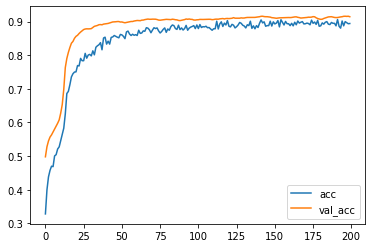

In [19]:
losses[['acc','val_acc']].plot()

<AxesSubplot:>

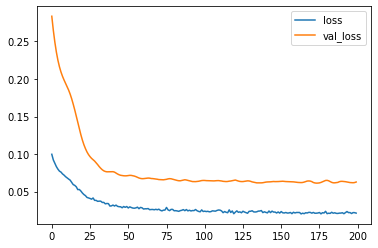

In [20]:
losses[['loss','val_loss']].plot()

# Evaluation

In [21]:
# Get the labels for test set
y_test = target[test_mask]

In [22]:
# Prediction of the whole graph
y_pred = model.predict([X, A],batch_size=N)

In [23]:
report = classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred[test_mask],axis=1))
print('GCN Classification Report for test set: \n {}'.format(report))

GCN Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2324
           1       0.93      0.90      0.92      4598
           2       0.93      0.92      0.93      4929
           3       0.93      0.93      0.93      4019

    accuracy                           0.92     15870
   macro avg       0.91      0.91      0.91     15870
weighted avg       0.92      0.92      0.92     15870



In [24]:
report = classification_report(np.argmax(target,axis=1), np.argmax(y_pred,axis=1))
print('GCN Classification Report for the whole graph: \n {}'.format(report))

GCN Classification Report for the whole graph: 
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      3327
           1       0.94      0.90      0.92      6495
           2       0.93      0.92      0.93      6880
           3       0.93      0.94      0.93      5768

    accuracy                           0.92     22470
   macro avg       0.91      0.92      0.91     22470
weighted avg       0.92      0.92      0.92     22470



# TSNE Plot

In [25]:
x_tsne = TSNE(n_components=2).fit_transform(y_pred)

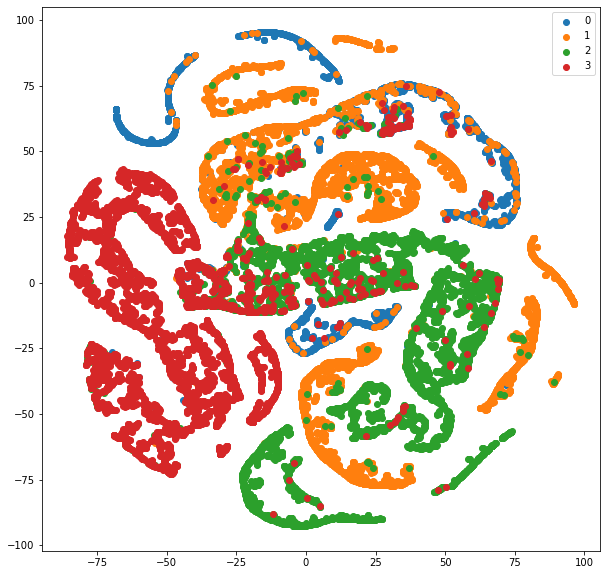

In [26]:
def plot_tSNE(target,x_tsne):
    color_map = np.argmax(target, axis=1)
    plt.figure(figsize=(10,10))
    for i in range(num_classes):
        indices = np.where(color_map==i)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=i)
    plt.legend()
    plt.show()
    
plot_tSNE(target,x_tsne)